# Generalized Linear Models for Traffic Accident Counts
In this notebook, GLM for the count of traffic crashes will be developed.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
from shapely.wkt import loads
from toolbox import *

## Read Dataset
The dataset is obtained from Chicago Data Potal.

In [2]:
# Read the data
df = pd.concat([pd.read_csv(f"Data/Traffic_Crashes_{i}.csv") for i in range(8)], ignore_index=True)

## Data Description
In the following, the basic information of the original dataset will be shown.

In [3]:
print(f"# of observations: {df.shape[0]}, # of features: {df.shape[1]}")

# of observations: 799526, # of features: 48


In [4]:
pd.set_option('display.max_columns', None)
df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,NaN,08/18/2023 12:50:00 PM,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",08/18/2023 12:55:00 PM,FOLLOWING TOO CLOSELY,DISTRACTION - FROM INSIDE VEHICLE,700,W,OHARE ST,1654.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,NaN,07/29/2023 02:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,Y,"OVER $1,500",07/29/2023 02:45:00 PM,FAILING TO REDUCE SPEED TO AVOID CRASH,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",2101,S,ASHLAND AVE,1235.0,NaN,NaN,NaN,NaN,NaN,NaN,4,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14,7,7,41.854120,-87.665902,POINT (-87.665902342962 41.854120262952)
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,NaN,08/18/2023 05:58:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"$501 - $1,500",08/18/2023 06:01:00 PM,FAILING TO REDUCE SPEED TO AVOID CRASH,UNABLE TO DETERMINE,3422,N,LONG AVE,1633.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,1.0,0.0,17,6,8,41.942976,-87.761883,POINT (-87.761883496974 41.942975745006)
3,004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...,NaN,11/26/2019 08:38:00 AM,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,ONE-WAY,NaN,CURVE ON GRADE,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",11/26/2019 08:38:00 AM,UNABLE TO DETERMINE,NOT APPLICABLE,5,W,TERMINAL ST,1655.0,Y,Y,NaN,NaN,NaN,NaN,2,FATAL,1.0,1.0,0.0,0.0,0.0,1.0,0.0,8,3,11,NaN,NaN,NaN
4,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,NaN,08/18/2023 10:45:00 AM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,OTHER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",08/18/2023 10:48:00 AM,FOLLOWING TOO CLOSELY,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,3,W,TERMINAL ST,1653.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10,6,8,NaN,NaN,NaN


In [5]:
df.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,799526.000000,1.990060e+05,799526.000000,799521.000000,799526.000000,797771.000000,797771.000000,797771.000000,797771.000000,797771.000000,797771.000000,797771.0,799526.000000,799526.000000,799526.000000,794081.000000,794081.000000
mean,28.403780,1.333032e+01,3688.695708,1243.135123,2.034823,0.189443,0.001187,0.019997,0.106981,0.061278,2.004076,0.0,13.201700,4.123786,6.756523,41.854820,-87.673497
std,6.177193,2.961623e+03,2888.049772,705.252405,0.452526,0.565504,0.037333,0.165503,0.421910,0.318553,1.158045,0.0,5.568989,1.980238,3.423399,0.336628,0.684215
min,0.000000,0.000000e+00,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.936193
25%,30.000000,2.000000e+00,1249.000000,714.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,4.000000,41.782440,-87.721733
50%,30.000000,2.000000e+00,3201.000000,1211.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.874778,-87.674114
75%,30.000000,4.000000e+00,5600.000000,1822.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,10.000000,41.924350,-87.633304
max,99.000000,1.191625e+06,451100.000000,6100.000000,18.000000,21.000000,4.000000,10.000000,21.000000,15.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


## Preprocessing

### Reducing demension
* To create GLM, we need to create a count data from the original data.
* Creating the count data lead to aggregating the original data.
* We will drop features which cannot be aggregated in advance.

In [12]:
df = df[["CRASH_DATE", "INJURIES_TOTAL", "INJURIES_FATAL", "CRASH_DAY_OF_WEEK", "LATITUDE", "LONGITUDE"]]

### Handling date time variables
* Deviding the variable "**CRASH_DATE**" into separete date time variables: "**CRASH_DATE_year**", "**CRASH_DATE_month**", "**CRASH_DATE_day**", "**CRASH_DATE_hour**", "**CRASH_DATE_minute**", "**CRASH_DATE_second**"

In [13]:
df = datetime_transformer(df, ["CRASH_DATE"])

### Removing obsevations prior to September 2017
* The observations are collected from 2015, but the observations from 2015 to August 2017 are collected from a part of the city.

In [17]:
df.drop(index=df[(df.CRASH_DATE_year<2016)].index, inplace=True)
df.drop(index=df[(df.CRASH_DATE_year==2017) | (df.CRASH_DATE_month<=8)].index, inplace=True)

### Handling missing value
* Removing observations with any missing values.

In [14]:
# show features with missing values and its counts and percentage
miss_num = df.isna().sum()[df.isna().sum() > 0]
miss_ratio = miss_num * 100 / df.shape[0]
df_miss = pd.DataFrame(data=[miss_num, miss_ratio], index=["# of missing value", "Percentage of missing value"]).T
df_miss

,# of missing value,Percentage of missing value
INJURIES_TOTAL,1755.0,0.219505
INJURIES_FATAL,1755.0,0.219505
LATITUDE,5445.0,0.681029
LONGITUDE,5445.0,0.681029


In [15]:
# drop rows with missing value
df.dropna(axis=0, inplace=True)

### Removing constant features
* Removing constant features, which means features with only one value.

In [16]:
# remove constant features
const_features = df.nunique()[df.nunique()==1].index
df.drop(columns=const_features, inplace=True)

### Removing unreliable observations
* There are some unreliable values in "CRASH_DATE_year", "LONGITUDE", and "LATITUDE".
* The observations containing unrealiable values will be removed.

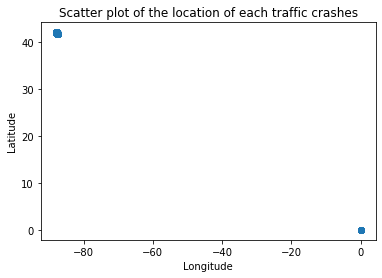

In [18]:
plt.scatter(df.LONGITUDE, df.LATITUDE)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter plot of the location of each traffic crashes")
plt.show()

Chicago is a city in the U.S., so the data in the bottom right in the above graph have errors in their location information.

In [19]:
df.drop(index=df[df.LATITUDE < 10].index, inplace=True)

### Feature Engineering
* Creating the target variable "**Severity**" from "**INJURIES_TOTAL**" and "**INJURIES_FATAL**".  
* "Severity" has three levels:  
    * 3: "INJURIES_TOTAL" $>=3$ or "INJURIES_FATAL" $>= 1$  
    * 2: $1<=$ "INJURIES_TOTAL" $<=2$  
    * 1: "INJURIES_TOTAL" $=0$

In [20]:
df = create_severity(df)

* Creating a new feature, which value is community area name in the city of Chicago

In [21]:
# read community area data
df_comm = pd.read_csv("Data/CommAreas.csv")

# convert the data type of 'the_geom' into the appropriate type: Multipolygon 
df_comm['the_geom'] = df_comm['the_geom'].apply(loads)

# Create Point object
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

series_comm = pd.Series([np.nan]*gdf.shape[0], index=gdf.index)
gdf_geom = gdf.geometry
df_comm_geom = gpd.GeoSeries(df_comm.the_geom)
for i in range(gdf.shape[0]):
    temp = df_comm_geom.contains(gdf_geom.iloc[i])
    if np.any(temp):
        series_comm.iloc[i] = df_comm.COMMUNITY[temp[temp==True].index[0]]
        
df["Community_area"] = series_comm

### Removing observations outside of Chicago city
* Removing observations in which the traffic crashes occured outside of Chicago city

In [22]:
# show the number of observations outside of Chicago city
df.Community_area.isna().sum()

126

In [23]:
# remove observations outside of Chicago city
df.dropna(axis=0, inplace=True)

In [24]:
df.head()

,INJURIES_TOTAL,INJURIES_FATAL,CRASH_DAY_OF_WEEK,LATITUDE,LONGITUDE,CRASH_DATE_year,CRASH_DATE_month,CRASH_DATE_day,CRASH_DATE_hour,CRASH_DATE_minute,Severity,Community_area
20,0.0,0.0,4,41.744152,-87.585945,2023,9,20,12,57,1,AVALON PARK
26,0.0,0.0,4,41.921730,-87.663234,2023,9,6,18,45,1,LINCOLN PARK
34,0.0,0.0,4,41.937252,-87.776321,2023,9,6,11,0,1,BELMONT CRAGIN
35,2.0,0.0,4,41.910530,-87.667051,2023,9,6,0,59,2,WEST TOWN
46,2.0,0.0,4,41.749913,-87.634585,2023,9,6,15,48,2,CHATHAM


### Creating a new data frame
* creating a new data frame used for developing GLM
* The new data frame contains "Count", "Month", "Time_frame", "Day_of_week", "Severity", and "Community_area" as its features